Lujain Madi Ali Al-Smadi   32009303047

After Training, this notebook is for make predict

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# **Downloading and Extracting Dataset**

In [ ]:
!kaggle datasets download -d anshtanwar/pets-facial-expression-dataset

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
pets-facial-expression-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip training set
local_zip = '/content/pets-facial-expression-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./pets-facial-expression-dataset')


zip_ref.close()

In [ ]:
train_data_dir = '/content/pets-facial-expression-dataset/Master Folder/train'
valid_data_dir = '/content/pets-facial-expression-dataset/Master Folder/valid'
test_data_dir = '/content/pets-facial-expression-dataset/Master Folder/test'

data_dir = '/content/pets-facial-expression-dataset'


ds_name = 'Pets Facial Expression'

# **Data Path and DataFrame Creation**

In [ ]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue

        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

#**Data Splitting**

In [ ]:
#Split dataframe into train, valid, and test
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

#**Data Augmentation and Generators**

In [ ]:
#Create Image Data Generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


#**Model Definition and Training**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                

Saving 0447463001544828845.jpg to 0447463001544828845 (1).jpg
1/1 [==============================] - 0s 286ms/step
[0.03052574 0.00613983 0.9602824  0.00305212]
1/1 [==============================] - 0s 300ms/step


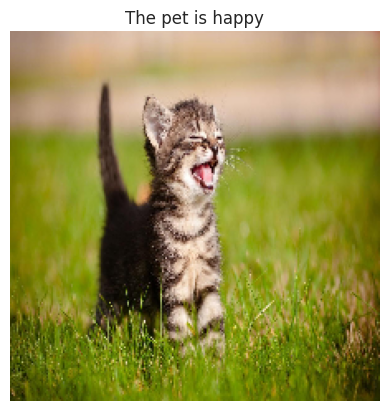

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_and_display(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to the class label
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image with the prediction
    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title("The pet is normal")
    else:
        plt.title(f"The pet is {predicted_class_label}")
    plt.show()

# Load the model weights
model.load_weights('/content/Pets_Facial_Expression_model.h5')

# Define the class labels
class_labels = ['Angry', 'Other', 'Sad', 'Happy']

# Upload the images
uploaded = files.upload()

# Process and predict each uploaded image
for fn in uploaded.keys():
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)

    images = np.vstack([img_array])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    predict_and_display(path, model)
